$$%
\newcommand{\BB}{{\boldsymbol B}}%
\newcommand{\cc}{{\boldsymbol c}}%
\let\dd\relax%
\newcommand{\dd}{{\boldsymbol d}}%
\newcommand{\DD}{{\boldsymbol D}}%
\newcommand{\Id}{{\boldsymbol I}}%
\newcommand{\HH}{{\boldsymbol H}}%
\newcommand{\RR}{{\boldsymbol R}}%
\newcommand{\TT}{{\boldsymbol T}}%
\newcommand{\VV}{{\boldsymbol V}}%
\newcommand{\WW}{{\boldsymbol W}}%
\newcommand{\ww}{{\boldsymbol w}}%
\newcommand{\XX}{{\boldsymbol X}}%
\renewcommand{\aa}{{\boldsymbol a}}%
\newcommand{\xx}{{\boldsymbol x}}%
\newcommand{\yy}{{\boldsymbol y}}%
% Math Symbols
\newcommand{\rrh}{{\boldsymbol \rho}}%
\newcommand{\lla}{{\boldsymbol \lambda}}%
\newcommand{\ssi}{{\boldsymbol \sigma}}%
\newcommand{\SSi}{{\boldsymbol \Sigma}}%
\newcommand{\eps}{{\boldsymbol \epsilon}}%
\newcommand{\GGa}{{\boldsymbol \Gamma}}%
\newcommand{\bz}{{\boldsymbol 0}}%
\DeclareMathOperator{\car}{CAR}%
\newcommand{\N}{\mathcal N}%
\newcommand{\iid}{\stackrel{iid}{\sim}}%
\newcommand{\ud}{\, \mathrm{d}}%
\newcommand{\tmin}{t_{\mathrm{min}}}%
\newcommand{\tmax}{t_{\mathrm{max}}}%
\newcommand{\carp}{\mathrm{CAR}(p)}
$$
# probDE: Probabilistic solution of ordinary differential equations

*Mohan Wu, Martin Lysy*

---

## Description

**probDE** is a Python library that uses [probabilistic numerics](http://probabilistic-numerics.org/) to solve ordinary differential equations (ODEs).  That is, most ODE solvers (such as [Euler's method](https://en.wikipedia.org/wiki/Euler_method)) produce a deterministic approximation to the ODE on a grid of size $\delta$.  As $\delta$ goes to zero, the approximation converges to the true ODE solution.  Probabilistic solvers such as **probDE** also output a solution an a grid of size $\delta$; however, the solution is random.  Still, as $\delta$ goes to zero we get the correct answer.

**probDE** provides a probabilistic solver for univariate ordinary differential equations (ODEs) of the form

\begin{equation*}
  \ww'\xx_t = f(\xx_t, t), \qquad \xx_L = \aa,
\end{equation*}

where $\xx_t = \big(x_t^{(0)}, x_t^{(1)}, ..., x_t^{(q)}\big)$ consists of the first $q$ derivatives of the process $x_t = x_t^{(0)}$, and a solution is sought on the interval $t \in [L, U]$.  

**probDE** implements the probabilistic solver of [Chkrebtii et al (2016)](https://projecteuclid.org/euclid.ba/1473276259).  This begins by putting a [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) prior on the ODE solution, and updating it sequentially as the solver steps through the grid.

## Walkthrough

To illustrate, let's consider the following ODE example of order $q = 2$:

\begin{equation*}
x_t^{(2)} = \sin(2t) − x_t^{(0)}, \qquad \xx_0 = (-1, 0, 1),
\end{equation*}

where the solution $x_t$ is sought on the interval $t \in [0, 10]$.  In this case, the ODE has an analytic solution,

\begin{equation*}
x_t = \tfrac 1 3 \big(2\sin(t) - 3\cos(t) - \sin(2t)\big).
\end{equation*}

To approximate the solution with the probabilistic solver, the Gaussian process prior we will use is a so-called [Continuous Autoregressive Process](https://CRAN.R-project.org/package=cts/vignettes/kf.pdf) of order $p$, 

\begin{equation*}
\XX_t \sim \car_p(\lla, \rrh, \sigma).
\end{equation*}

Here $\XX_t = \big(x_t^{(0)}, ..., x_t^{(p-1)}\big)$ consists of $x_t$ and its first $p-1$ derivatives. The $\carp$ model specifies that each of these is continuous, but $x_t^{(p)}$ is not. Therefore, we need to pick $p > q$. It's usually a good idea to have $p$ a bit larger than $q$, especially when we think that the true solution $x_t$ is smooth. However, increasing $p$ also increases the computational burden, and doesn't necessarily have to be large for the solver to work.  For this example, we will use $p=4$. The tuning parameters of the $\carp$ prior are:

- The mean vector $\lla$.  By default we will set this to 0.
- The scale parameter $\sigma$.
- The "roots" of the process $\rrh = (\rho_0, \ldots, \rho_{p-1})$.  These can be any distinct set of negative numbers.  We suggest parametrizing them as $\rho_0 = -1/\tau$ and $\rho_k = -(1 + \tfrac{k}{10(p-1)})$ for $k > 0$, in which case $\tau$ becomes a decorrelation-time parameter.

Finally, we need a way to initialize the remaining derivatives $\yy_t = \big(x_t^{(q+1)}, ..., x_t^{(p-1)}\big)$ at time $t = L$. Since the $\carp$ process has a multivariate normal stationary distribtuion, we suggest initializing $\yy_L \sim p(\yy_L \mid \xx_L = \aa)$, i.e., as a random draw from this stationary distribution conditional on the value of $\xx_L = \aa$.  The Python code to implement all this is as follows.

In [27]:
# Imports needed
from math import sin, cos
import numpy as np
from BayesODE.Kalman.kalman_solver import kalman_solver
import matplotlib.pyplot as plt # for plotting

In [70]:
# RHS of ODE
def ode_fun(x_t, t):
    return sin(2*t) - x_t[0]

# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
q = 2 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
N = 100 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 10 

# Now we need the parameters for the solver
# First we need to generate roots, rho, for the CAR(p) prior
# We suggest using root_gen to parametrize them as desribed: rho_k = -exp(k/tau)
r0 = 10 # decorrelation parameter
roots = -np.append(1/r0, np.linspace(1, 1.1, p-1))
#r0 = 100
#roots = root_gen(r0, p)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
lamb = np.zeros(p)
#sigma = .1
sigma = .5

# Initial value, x0, for the IVP
a = np.array([-1.0, 0.0, 1.0])

# Draw y0 conditioned on x0 = a
#X0 = kalman_initial_draw(roots, sigma, a, p)

# Run the solver to get an approximation
Xn, Xn_mean, Xn_var = kalman_solver(ode_fun, L, U, N, lamb, sigma, roots, w_vec, a)

To see how well this approximation does against the exact solution, we can graph them together. First, we will define the functions of the exact solution for this example.

In [71]:
# Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

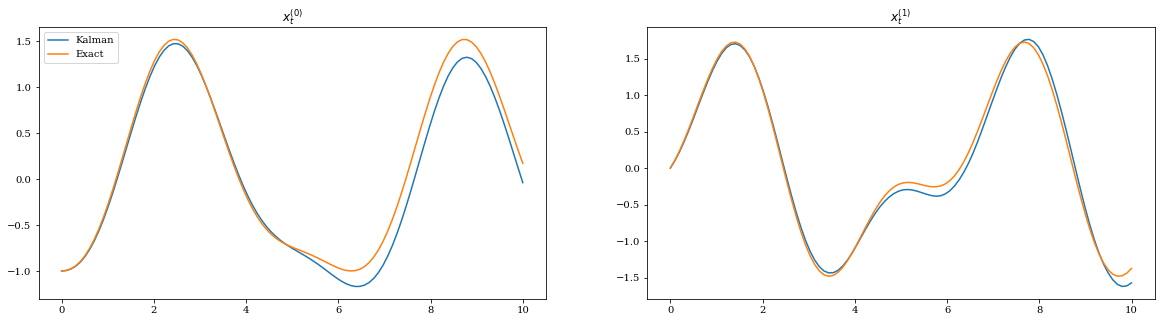

In [75]:
# Get exact solutions for x^{(0)}, x^{(1)}
tseq = np.linspace(L, U, N)
exact_x = np.zeros(N)
exact_x1 = np.zeros(N)
for t in range(N):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])

# Plot them
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, Xn[:,0], label = 'Kalman')
axs[0].plot(tseq, exact_x, label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, Xn[:,1], label = 'Kalman')
axs[1].plot(tseq, exact_x1, label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

### Graph in README 

To produce the graphs in the README file, we just need to run the following function. It runs `kalman_solver` for `draws` samples for each of the three `N`: 50, 100, 200. It also does the Euler method as well as getting the exact solution to compare the accuracy of the kalman draws.

In [37]:
from BayesODE.Examples.readme_graph import readme_solve
draws = 100
#readme_graph(ode_fun, p, L, U, N, w_vec, a, draws)

N = [50, 100, 200]
Tau = [1/.04, 1/.01, 1/.1]
Sigma = [.5, .5, .001]
tseq = [None] * 3
Xn = [None] * 3
x_euler = [None] * 3
x_exact = [None] * 3

# calculations
for i in range(3):
    tseq[i], Xn[i], x_euler[i], x_exact[i] = readme_solve(fun=ode_fun, w=w_vec, tmin=L, tmax=U, n_eval=N[i],
                                                          p=p, tau=Tau[i], sigma=Sigma[i], x_init=a,
                                                          draws=draws)

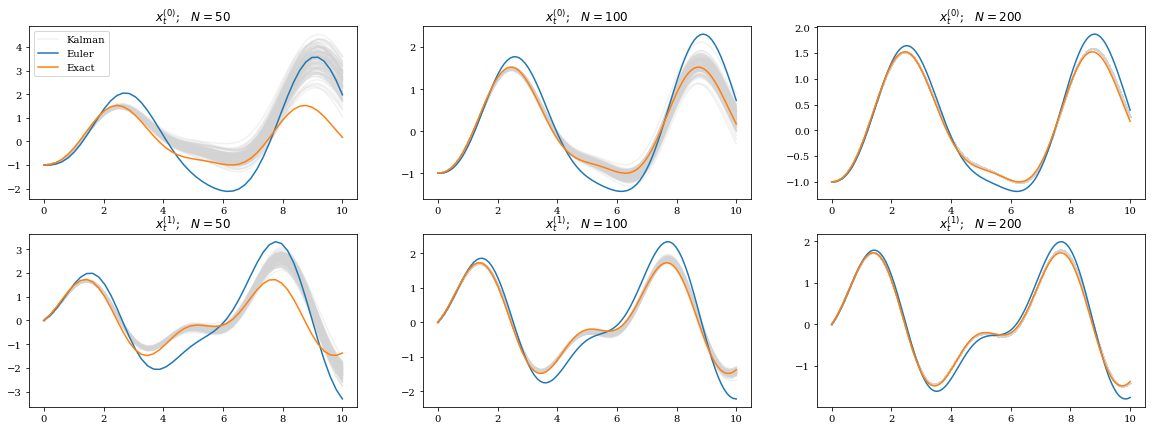

In [68]:
# create plot
_, axs = plt.subplots(2, 3, figsize=(20, 7))

for prow in range(2):
    for pcol in range(3):
        # plot Kalman draws
        for i in range(draws):
            if i == (draws - 1):
                axs[prow, pcol].plot(tseq[pcol], Xn[pcol][i,:,prow], 
                                     color="lightgray", alpha=.3, label="Kalman")
            else:
                axs[prow, pcol].plot(tseq[pcol], Xn[pcol][i,:,prow], 
                                     color="lightgray", alpha=.3)
        # plot Euler and Exact
        axs[prow, pcol].plot(tseq[pcol], x_euler[pcol][:,prow], 
                             label="Euler")
        axs[prow, pcol].plot(tseq[pcol], x_exact[pcol][:,prow], 
                             label="Exact")
        # set legend and title
        axs[prow, pcol].set_title("$x^{(%s)}_t$;   $N=%s$" % (prow, N[pcol]))
        #axs[prow, pcol].set_ylabel("$x^{(%s)}_t$" % (prow))
        if (prow == 0) & (pcol == 0):
            axs[prow, pcol].legend(loc='upper left')

## Installation

Download the repo from GitHub and then install with the `setup.py` script:

```bash
git clone https://github.com/mlysy/probDE.git
cd probDE
python setup.py install
```

**NOTES:** 

- Should we write the roots in such a way that they need to be all positive, or all negative?
- reparametrize roots via $\tau$.  Did we do this correctly, i.e., can one of the roots always be 1???
- The user-facing code should not require them to e.g., zero pad things, etc.  We should have functions e.g., in `utils` which do this for them inside of `kalman_ode_higher`.
- Inputs to `kalman_ode_higher`:

    - `tmin`, `tmax`, `N`.
    - `w`, `fun`, `X0`.  `X0` can be shorter, i.e., `x0`, in which case random draw is computed inside `kalman_ode_higher`.
    - `roots`, `sigma`, `lambda`.  Can have `lambda` default to 0.

- Is there any advantage to having the whole `kalman` solver be a class???  Maybe not now, but we should have one user-facing function that calls `kalman_ode_higher` and `higher_mvncond`.

- Also, let's put all code that is just "scratch" for you and me into a single folder somewhere.  Maybe `probDE/BayesODE/depreciated`.

- Please write some `.py` files to produce the Chkrebtii figure.  Those files can just be `import`ed here, because we don't really need to see the contents in the tutorial.

**probDE** currently supports two types of Gaussian process priors: 

- [Continuous Autoregressive](https://CRAN.R-project.org/package=cts/vignettes/kf.pdf) processes.
- Arbitrary Gaussian processes.

The advantage of the former is that calculations scale linearly with $\delta$.  The latter is much slower, and mainly presented here for testing code.

In [36]:
N = 50
tau = 1/.04
sigma = .5
tseq_50, Xn_50, euler_50, exact_50 = readme_solve(fun=ode_fun, w=w_vec, tmin=L, tmax=U, n_eval=N,
                                                  p=p, tau=tau, sigma=sigma, x_init=a,
                                                  draws=draws)

N = 100
tau = 1/.01
sigma = .5
tseq_100, Xn_100, euler_100, exact_100 = readme_solve(fun=ode_fun, w=w_vec, tmin=L, tmax=U, n_eval=N,
                                                      p=p, tau=tau, sigma=sigma, x_init=a,
                                                      draws=draws)


N = 200
tau = 1/.1
sigma = .001
tseq_200, Xn_200, euler_200, exact_200 = readme_solve(fun=ode_fun, w=w_vec, tmin=L, tmax=U, n_eval=N,
                                                      p=p, tau=tau, sigma=sigma, x_init=a,
                                                      draws=draws)

[]